# Knowledge Based Information Retrieval in COVID-19
> __Knowledge based information retrieval, KBIR, is commonly known as retrieving topic relevent information based on the pre-existing knowledge database, or domain knowledge system. In this notebook, our team presents a novel pipeline for Knowledge Based Information Retrieval, we take COVID-19 related topic as our demo example, but the methodology could be extended to other topic in biomedical or other domain.__
<br>
<br>


> __Keyword:__ [Knowledge Graph](#kg), [UMLS](#kg), MeSH, SNOMED_CT, NER, Graph Query, [Question Answering](#qa)<br>
> __Team members:__Rui Qiu, Xiaonan Ji, Po-Yin Yen, Marcelo Lopetegui<br>
> __Version:__ 2.0 <br>
> __Last update:__ 06/16/2020

## Content
* 1. [Methodology](#methodology)
    * 1.1 [Medical Ontology](#kg)
    * 1.2 [Medical concept extraction-Metamaplite](#mce)
    * 1.3 [Paper Concept Graph](#pcg)
    * 1.4 [Merged KG-concepts & papers](#mkg)
    * 1.5 [Best paper candidates](#bpc)
    * 1.6 [QA for quick answer checking](#qa)
* 2. [Result display](#res)

### 1. Methodology <a id="methodology"></a>

__The general methodology__ we use in Knowledge Based Information Retrieval(KBIR_ consists of six steps (As shown in workflow graph below). <br>


![general workflow](https://drive.google.com/uc?export=view&id=1uVbv7bbx0YAbxIGsua4jcoHOhywUfVWv)

![General Workflow](https://drive.google.com/uc?export=view&id=17sbcv4IxI_A9NeMlPoQq6_vWjCxUNFNw)

### 1.1  Medical Ontology <a id='kg'></a>
> <br>
The first step is knowledge graph buildup, which, we benefited from many well strcutured Biomedical Databases like MeSH and SNOMEDCT_US, and also the UMLS, which serves as a unified version for all Medical concept information. Here, we took both the hierachical relationship of each concept and also their semantic relationship into consideration, those relationship could be, for example, <code>CAUSTIVE_AGENT</code> could be the relationship between concept <code>COVID-19</code> and <code>2019-nCoV</code> in the format of (<code>COVID-19</code> <code>CAUSTIVE_AGENT</code> <code>2019-nCoV</code>), by having this kind of knowledge as our base, we are able execuss the question query in a more intelligent way, by having background domain knowledge come with us. <br>
> The example subgraph of our wholee Knowledge Graph is display below, which center at <code>Disease caused by 2019 novel coronavirus</code> and directly related with four other medical concepts in relationships <code>CAUSATIVEE_AGENT</code>, <code>PATHOLOGICAL_PROCESS</code>, <code>ASSOCIATED_FINDING</code> and <code>IS_A</code>
<br>
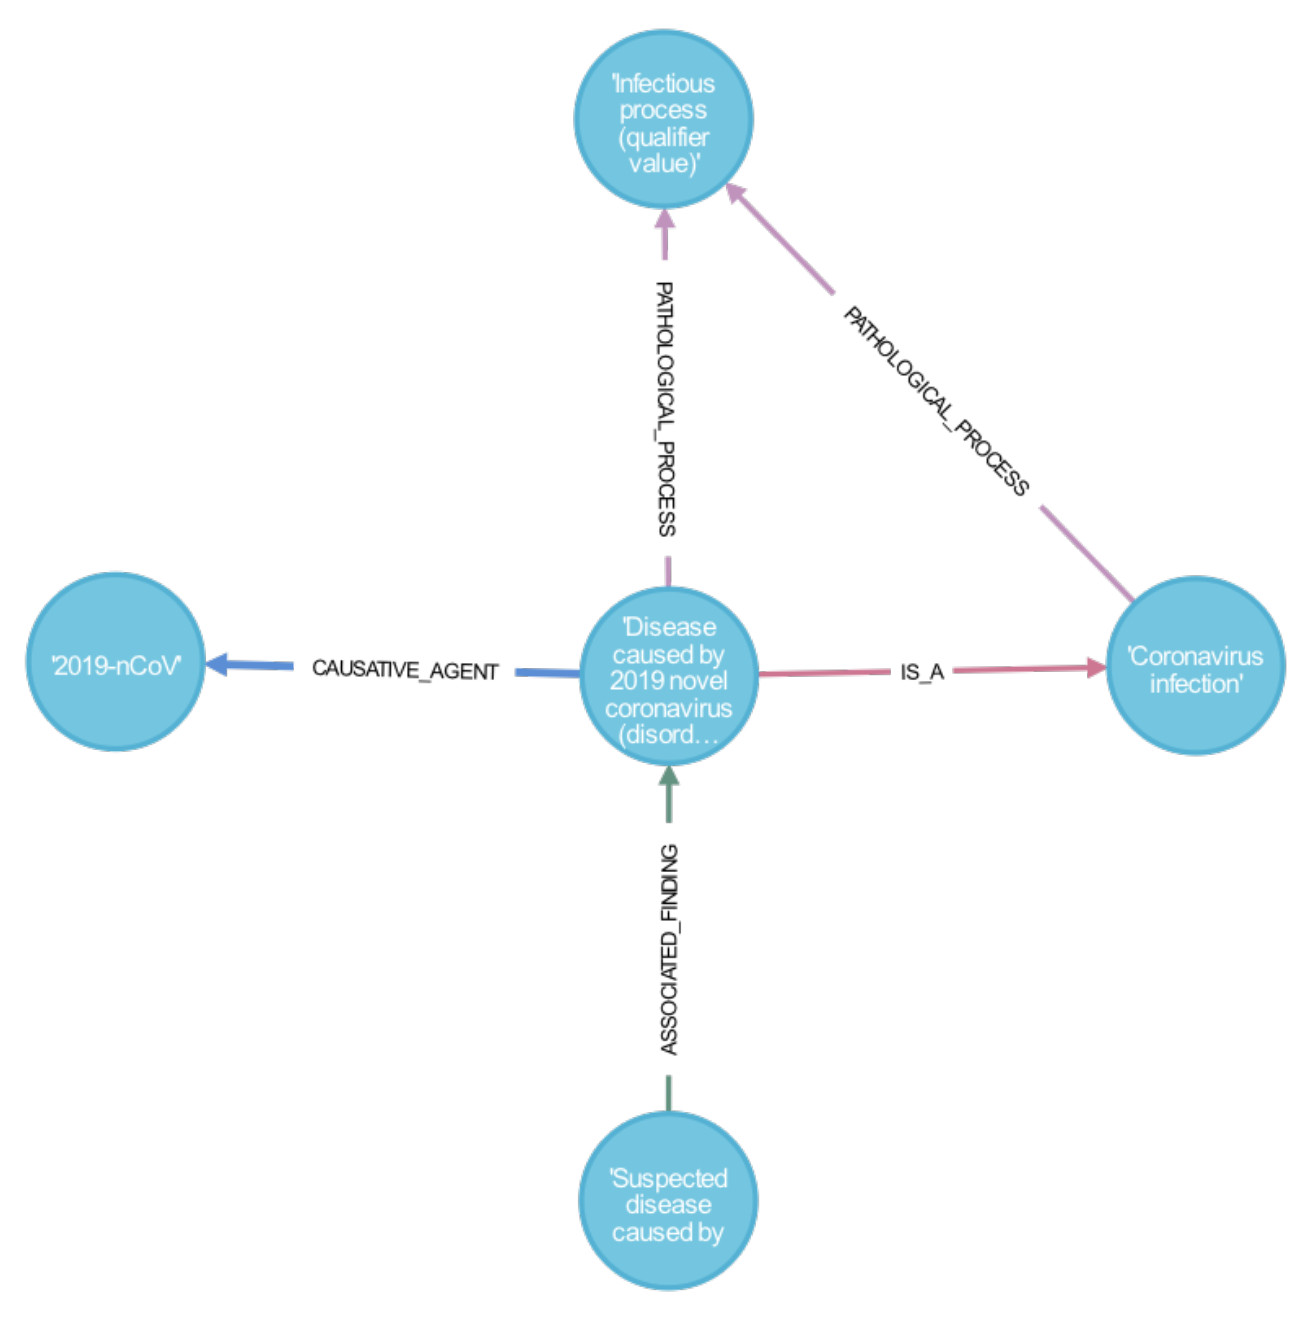

### 1.2 Medical Concept Extraction & 1.3 Paper Graph <a id='mce'></a> <a id="pcg"></a>
> The second step of this pipeline is to buildup connection between each paper in COVID-19 database and the pre-existing medical concept knowledge graph, NER(Named Entity Reecognition) tool are what we using during this step. Specifically, we used <a href="https://metamap.nlm.nih.gov/MetaMapLite.shtml">Metamaplite </a>,  which is provided by UMLS to detect UMLS concepts, and semantic types comes with it. Once we detected all the informative medical concepts of each paper, we are able to link each paper with the covered concepts, we call this relationship <code>COVER_TERM</code>, check how it looks like from below graph, where orange bubble stands for Paper node and blue bubbles stands for concepts node
<img src="https://drive.google.com/uc?export=view&id=1BFt6FbJUrLYo4inqsK1wy_8zbIcRdfeH">

### 1.4 Merged Graph <a id='mkg'></a>
> By finishing recognize use medical concepts from each paper, we are able to merge the paper node into existing Medical knowledge graph, the general display would be also like the graph above, showing both Paper node,  Medical Concept node as well as relationship between concept node

### 1.5  Best Paper candidate (Query mapping) <a id='bpc'></a>
> After we finished our merged graph, we are ready for our incoming guest, the __query__ part. <br>
> The general idea of our query is following the intuition of graph query, finding the nearest <code>Paper</code> of <code>Query</code>, by using the connection and relationship of <code>Concept relationship</code>. <br>
For example, the information showed in the below graph is generally demonstrateing this process:
<img src="https://drive.google.com/uc?export=view&id=1ZcvAkIg0-8xnopfD80qFQO8qef7T3V8F">
> The graph on the left side is showing the <code>COVER_TERM</code> relationship of the query *"Effectiveness of case isolation of exposed individuals of COVID-19"*, and the right side is showing the megerd <code>Query</code>,<code>Concept</code> and <code>Paper</code>, from where, we could find our target query a cloest paper by the merging graph.

* The Biggest advantage of merging using  knowledge graph base as start point could also be shown in here, for example,if the <code>query</code> is talking about <code>COVID-19</code>, and the paper may not directly talking about <code>COVID-19</code>, rather talking about <code>2019-nCoV</code>, a well-performed algorithm should be able to find these two concepts are related, either by using language model, like word embedding to find out these two concepts appears together frequently, or like what we used here, by throwing concepts relationship knowledge graph and consiering cloest paper based on this knowledge. And the solution we provided by using knowledge based graph search can achieve better performance in both the training time and savings of training materials at the cost of pre-existing human labor in annotating those concepts' relationships. The best paper result demo for a query can be seen at the below graph. (The similarity score was calculated by $\frac{1}{concept\_distance + 1}$ )
<img src="https://drive.google.com/uc?export=view&id=1vnfTFXStKWgWhpY864GaCqhA9S19nAr7">

### 1.6 QA
> The last step we do is to leveraging the current state of art transformer model's amazing performance in doing question answering, specifically, we use AlBert model in finding quick answers from each paper, details of this work could be find <a href="https://www.kaggle.com/yenlab/semantic-query-where-does-good-result-come-from">HERE</a>

## Below is our coding part and result demo

In [ ]:
### Install and import necessary packages
!pip install neo4j==1.7.6
import requests
import concurrent
import json
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from neo4j import GraphDatabase, basic_auth
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

### 2.1 Helper function

In [ ]:
### Helper function
def snomed_cr_ui(ui,url = 'https://browser.ihtsdotools.org/snowstorm/snomed-ct/browser/MAIN/2020-03-09/concepts/'):
  res = requests.get(f"https://browser.ihtsdotools.org/snowstorm/snomed-ct/browser/MAIN/2020-03-09/concepts/{ui}")
  try:
    res = res.json()
    if res.get('error') == 'NOT_FOUND':
      with open(root_path+'SNOMED_UI_NOT_FOUND.txt', 'a') as f:
        f.write(f"{ui} not found\n") 
      return {}
    if not res.get('active') or not (res.get('classAxioms') or res.get('relationships')):
      return {}
    else:
      out = {}
      out['reference'] = [ui]
      out['conceptId'] = res['conceptId']
      out['pt'] = res['pt']['term']
      out['classAxioms'] = []
      out['relationships'] = []
      for axiom in res['classAxioms']:
        for relationship in axiom['relationships']:
          if relationship['target']['conceptId'] not in out['reference']:
            out['reference'].append(relationship['target']['conceptId'])
          out['classAxioms'].append({
              'type':{
                  'conceptId':relationship['type']['conceptId'],
                  'pt':relationship['type']['pt']['term']
              },
              'target':{
                  'conceptId':relationship['target']['conceptId'],
                  'pt':relationship['target']['pt']['term']
              },
              'characteristicType': relationship['characteristicType']
          })
      for relationship in res['relationships']:
        if relationship['target']['conceptId'] not in out['reference']:
          out['reference'].append(relationship['target']['conceptId'])
        out['relationships'].append({
            'type':{
                'conceptId':relationship['type']['conceptId'],
                'pt':relationship['type']['pt']['term']
            },
            'target':{
                'conceptId':relationship['target']['conceptId'],
                'pt':relationship['target']['pt']['term']
            },
            'characteristicType': relationship['characteristicType']
        })
      return out
  except ValueError as e:
    print(f"Problem appears at {ui}")
    print(res.text)
    with open(root_path+'SNOMED_UI_NOT_FOUND.txt', 'a') as f:
        f.write(f"{ui} appears problem") 
    return {}

def snomed_cr_term(term, url='https://browser.ihtsdotools.org/snowstorm/snomed-ct/browser/MAIN/2020-03-09/descriptions?&limit=100&term=<>&active=true&conceptActive=true&lang=english'):
  term = '%20'.join(term.lower().split())
  try:
    candidate = requests.get(url.replace('<>', term)).json()
    if not candidate.get('numberOfElements') > 0:
      return {}
    else:
      preferred_item = candidate['items'][0]
      return snomed_cr_ui(preferred_item['concept']['id'])
  except:
    with open(root_path+'SNOMED_UI_NOT_FOUND.txt', 'a') as f:
        f.write(f"{term} appears problem") 
    return {}

In [ ]:
def get_tgt_ticket(url='https://utslogin.nlm.nih.gov/cas/v1/api-key', apikey='888568eb-3904-4ffd-971a-7b553c8ce6dc'):
    '''
      Retrieve TGT for UMLS API(required)
      : Required, must get TGT before retrieve service ticket and running UMLS query API

      @Param:
        url: string, url like
          url of API
        apikey: API key of UMLS, find from personal profile

      @return:
        TGT: string
          TGT ticket
    '''
    res = requests.post(url, [('apikey',apikey)])
    start_index = res.text.index('TGT-')
    end_index = res.text.index('-cas')
    TGT = res.text[start_index: end_index+4]
    return TGT

def get_service_ticket(TGT_ticket, url="https://utslogin.nlm.nih.gov/cas/v1/api-key/", service="http://umlsks.nlm.nih.gov"):
    '''
      Retrieve service ticket for UMLS API (required)
      : Must running after got TGT ticket and before running actual query UMLS API

      @Param:
        TGT_ticket: str
          TGT ticket got from func_get_tgt_ticket
        url:string, url like
          url of API
        service: string
          required for this function, use default please
    '''
    res = requests.post(f'{url}{TGT_ticket}', [('service', service)])
    service_ticket = res.text
    return service_ticket

In [ ]:
def metamaplite_query(corpus):
  '''
    Use Metamap API to retrieve list of concept, cui and other information
    : This part doesnot require API TGT and API ticket

    @Param:
      corpus: str
        plain text, string of corpus 

    @return:
      query_res: arr
        array like with json inside result of query result
  '''
  params = []
  params.append(('inputtext', corpus))
  params.append(('docformat', 'freetext'))
  params.append(('resultformat', 'json'))
  params.append(('sourcesString', 'MTH,MSH'))
  params.append(('semanticTypeString', 'all'))
  acceptfmt = 'text/plain'
  url = 'https://ii-public1.nlm.nih.gov/metamaplite/rest/annotate'
  headers = {'Accpet': acceptfmt}
  resp = requests.post(url, params, headers=headers)
  start_index = resp.text.index('<pre>')
  end_index = resp.text.index('</pre>')
  res = resp.text[start_index+5: end_index]
  res_dict = json.loads(res)

  query_res = []
  for item in res_dict:
    query_res.append(item['evlist'][0])
  return query_res

In [ ]:
def url_atoms_get(cui, url='https://uts-ws.nlm.nih.gov/rest/content/current/CUI/'):
  return f'{url}{cui}/atoms'

def atoms_(cui, rootSource='SNOMEDCT_US'):
  '''
    Module required: requests
  '''
  ## 1. get url 
  url = url_atoms_get(cui)
  tgt = get_tgt_ticket()
  service_ticket = get_service_ticket(tgt)
  res = requests.get(f'{url}?sabs={rootSource}&ticket={service_ticket}')
  try:
    res_json = res.json()
    return res_json
  except:
    return {}

In [ ]:
def metamap_snomedct_concept_generation_process(query):
  metamap_res = metamaplite_query(query)
  query_res = {}
  for concept in metamap_res:
    if not query_res.get(concept['conceptinfo']['cui']):
      query_res[concept['conceptinfo']['cui']] = {
          'Pos_List':[concept['start']],
          'times': 1,
          'cui':concept['conceptinfo']['cui'],
          'conceptstring':concept['conceptinfo']['conceptstring'],
          'preferredname':concept['conceptinfo']['preferredname']
      }
    else:
      query_res[concept['conceptinfo']['cui']]['times'] += 1
      query_res[concept['conceptinfo']['cui']]['Pos_List'].append(concept['start'])
  snomed_res = {}
  def item_fill(item):
    # term, value = item
    term_cui, value = item
    term = value['preferredname']
    atoms = atoms_(term_cui)
    if not atoms:
      tmp_res = snomed_cr_term(term)
      if not tmp_res:
        tmp_res_match = snomed_cr_term(value['conceptstring'])
        if not tmp_res_match:
          return 
        else:
          snomed_res[tmp_res_match['conceptId']] = value
          snomed_res[tmp_res_match['conceptId']]['ui'] = tmp_res_match['conceptId']
          snomed_res[tmp_res_match['conceptId']]['conceptInfo'] = tmp_res_match
          snomed_res['reference'] += snomed_res[tmp_res['conceptId']]['conceptInfo']['reference']
          return 
      else:
        snomed_res[tmp_res['conceptId']] = value
        snomed_res[tmp_res['conceptId']]['ui'] = tmp_res['conceptId']
        snomed_res[tmp_res['conceptId']]['conceptInfo'] = tmp_res
        snomed_res['reference'] += snomed_res[tmp_res['conceptId']]['conceptInfo']['reference']
        return 
    for atom in atoms['result']:
      if atom.get('rootSource') == 'SNOMEDCT_US' and atom.get('sourceConcept') != None:
        snomed_ui = atom.get('sourceConcept').split('/')[-1]
        snomed_res[snomed_ui] = value
        snomed_res[snomed_ui]['ui'] = snomed_ui
        snomed_res[snomed_ui]['conceptInfo'] = snomed_cr_ui(snomed_ui)
        if not snomed_res[snomed_ui]['conceptInfo']:
          del snomed_res[snomed_ui]
        else:
          snomed_res['reference'] += snomed_res[snomed_ui]['conceptInfo']['reference']
          break
  with concurrent.futures.ThreadPoolExecutor() as executor:
      executor.map(item_fill, query_res.items())
  return snomed_res

In [ ]:
def similar_paper_extract(conceptId):
  driver = GraphDatabase.driver(
      "bolt://54.236.27.163:7687", 
      auth=("neo4j", "6137830ppp"),encrypted=False)
  with driver.session() as session:
    res = session.read_transaction(direct_indirect_paper_retrieval,conceptId)
    driver.close()
  for distance,value in res.items():
    for paper in value:
      if similarity.get(paper['pp.CORD_UID']):
        similarity[paper['pp.CORD_UID']] += 1/(int(distance)+1)**2
      else:
        similarity[paper['pp.CORD_UID']] = 1/(int(distance)+1)**2
  return similarity

In [ ]:
def direct_indirect_paper_retrieval(tx, conceptId):
  record_0 = tx.run("""
  match p=((a {conceptId:'"""+conceptId+"""'})-[*0]-(c))
  where ALL(r in relationships(p) where type(r) <> 'COVER_TERM')
  match (c)<-[:COVER_TERM]-(pp)
  return pp.CORD_UID
  """).data()
  record_1 = tx.run("""
  match p=((a {conceptId:'"""+conceptId+"""'})-[*1]-(c))
  where ALL(r in relationships(p) where type(r) <> 'COVER_TERM')
  match (c)<-[:COVER_TERM]-(pp)
  return pp.CORD_UID
  """).data()
  # record_2 = tx.run("""
  # match p=((a {conceptId:'"""+conceptId+"""'})-[*2]-(c))
  # where ALL(r in relationships(p) where type(r) <> 'COVER_TERM')
  # match (c)<-[:COVER_TERM]-(pp)
  # return pp.CORD_UID
  # """)
  return {
      '0':record_0,
      '1':record_1
      # '2':record_2.data()
  }

def concept_distance(tx, conceptId_1, conceptId_2):
  record = tx.run("""
  match p=shortestPath(({conceptId:'"""+conceptId_1+"""'})-[*]-({conceptId:'"""+conceptId_2+"""'}))
  where ALL (r in relationships(p) where type(r)<>'COVER_TERM')
  return relationships(p)
  """).data()

  return record

def distance_paper_concept(tx, cord_uid, conceptId):
  record = tx.run("""
  match p=(({CORD_UID:'"""+cord_uid+"""'})-[:COVER_TERM]-({conceptId:'"""+conceptId+"""'}))
  return length(p) as lg
  """).data()
  if not record:
    record = tx.run("""
    match (a {CORD_UID:'"""+cord_uid+"""'})-[:COVER_TERM]-(c:SNOMEDCT_CONCEPT), p=shortestPath(({conceptId:'"""+conceptId+"""'})-[*]-(c))
    where ALL (r in relationships(p) where type(r)<>'COVER_TERM') AND c.conceptId <> '"""+conceptId+"""'
    return length(p)+1 as lg
    """).data() 
  return record

### Start

In [ ]:
root_path = "../input/CORD-19-research-challenge/"
metadata = pd.read_csv(root_path+'metadata.csv')
metadata.set_index('cord_uid', inplace=True)

In [ ]:
query_1 = "Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery."
query_2 = "Prevalence of asymptomatic shedding and transmission (e.g., particularly children)."
query_3 = "Seasonality of transmission"
query_4 = "Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding)."
query_5 = "Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood)."
query_6 = "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic)."
query_7 = "Natural history of the virus and shedding of it from an infected person"
query_8 = "Implementation of diagnostics and products to improve clinical processes"
query_9 = "Disease models, including animal models for infection, disease and transmission"
query_10 = "Tools and studies to monitor phenotypic change and potential adaptation of the virus"
query_11 = "Immune response and immunity"
query_12 = "Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings"
query_13 = "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings"
query_14 = "Role of the environment in transmission"

In [ ]:
def graph_query(query):
    '''
    pipeline
    '''
    query = (query + ' COVID-19') if 'COVID-19' not in query else query
    word_tokens = word_tokenize(query)
    filtered_query = [i for i in word_tokens if not i in stopwords]
    res = metamap_snomedct_concept_generation_process(' '.join(filtered_query))
    similarity = {}
    def similar_paper_extract(conceptId):
        driver = GraphDatabase.driver(
            "bolt://54.236.27.163:7687",  # IP address changed every time we start to run our DB, please contact with us to get access
        auth=("neo4j", "6137830ppp"),encrypted=False)
        with driver.session() as session:
            res = session.read_transaction(direct_indirect_paper_retrieval,conceptId)
            driver.close()
        for distance,value in res.items():
            for paper in value:
                if similarity.get(paper['pp.CORD_UID']):
                    similarity[paper['pp.CORD_UID']] += 1/(int(distance)+1)**2
                else:
                    similarity[paper['pp.CORD_UID']] = 1/(int(distance)+1)**2
    for key in res.keys():
        similar_paper_extract(key)
    similarity_sorted = sorted(similarity.items(), key=lambda item:item[1], reverse=True)
    return similarity_sorted.copy()

In [ ]:
query_list = {
    'query_1': query_1,
    'query_2': query_2,
    'query_3': query_3,
    'query_4': query_4,
    'query_5': query_5,
    'query_6': query_6,
    'query_7': query_7,
    'query_8': query_8,
    'query_9': query_9,
    'query_10': query_10,
    'query_11': query_11,
    'query_12': query_12,
    'query_13': query_13,
    'query_14': query_14    
}
query_res = {}
for query_id, query_text in query_list.items():
    print(f'---------------{query_id} is working------------------')
    query_res[query_id+'_res'] = graph_query(query_text)

query_res_df = {}
for query_id, query_res_list in query_res.items():
    res_list = [i[0] for i in query_res_list[0:50]]
    tobe_remove = []
    for cord_uid in res_list:
        if not cord_uid in metadata.index:
            tobe_remove.append(cord_uid)
    for i in tobe_remove:
        res_list.remove(i)
    query_res_df[query_id] = metadata.loc[res_list]

### 2. Result display <a id='res'></a>

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, TableColumn, StringFormatter, Circle, Div, Paragraph, Select,DataTable
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Slider,Dropdown
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column, row, gridplot
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_1_res']['title']),
    'publish_time':list(query_res_df['query_1_res']['publish_time']),
    'url': list(query_res_df['query_1_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_1_res']['title']),
    'abstract':list(query_res_df['query_1_res']['abstract']),
    'url': list(query_res_df['query_1_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_1}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, TableColumn, StringFormatter, Circle, Div, Paragraph, Select,DataTable
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Slider,Dropdown
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column, row, gridplot
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_2_res']['title']),
    'publish_time':list(query_res_df['query_2_res']['publish_time']),
    'url': list(query_res_df['query_2_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_2_res']['title']),
    'abstract':list(query_res_df['query_2_res']['abstract']),
    'url': list(query_res_df['query_2_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1><center>{query_2}<center></h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, TableColumn, StringFormatter, Circle, Div, Paragraph, Select,DataTable
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Slider,Dropdown
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column, row, gridplot
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_3_res']['title']),
    'publish_time':list(query_res_df['query_3_res']['publish_time']),
    'url': list(query_res_df['query_3_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_3_res']['title']),
    'abstract':list(query_res_df['query_3_res']['abstract']),
    'url': list(query_res_df['query_3_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1><center>{query_3}<center></h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, TableColumn, StringFormatter, Circle, Div, Paragraph, Select,DataTable
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Slider,Dropdown
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column, row, gridplot
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_4_res']['title']),
    'publish_time':list(query_res_df['query_4_res']['publish_time']),
    'url': list(query_res_df['query_4_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_4_res']['title']),
    'abstract':list(query_res_df['query_4_res']['abstract']),
    'url': list(query_res_df['query_4_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_4}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, TableColumn, StringFormatter, Circle, Div, Paragraph, Select,DataTable
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Slider,Dropdown
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column, row, gridplot
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_5_res']['title']),
    'publish_time':list(query_res_df['query_5_res']['publish_time']),
    'url': list(query_res_df['query_5_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_5_res']['title']),
    'abstract':list(query_res_df['query_5_res']['abstract']),
    'url': list(query_res_df['query_5_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_5}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, TableColumn, StringFormatter, Circle, Div, Paragraph, Select,DataTable
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Slider,Dropdown
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column, row, gridplot
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_6_res']['title']),
    'publish_time':list(query_res_df['query_6_res']['publish_time']),
    'url': list(query_res_df['query_6_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_6_res']['title']),
    'abstract':list(query_res_df['query_6_res']['abstract']),
    'url': list(query_res_df['query_6_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_6}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_7_res']['title']),
    'publish_time':list(query_res_df['query_7_res']['publish_time']),
    'url': list(query_res_df['query_7_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_7_res']['title']),
    'abstract':list(query_res_df['query_7_res']['abstract']),
    'url': list(query_res_df['query_7_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_7}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_8_res']['title']),
    'publish_time':list(query_res_df['query_8_res']['publish_time']),
    'url': list(query_res_df['query_8_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_8_res']['title']),
    'abstract':list(query_res_df['query_8_res']['abstract']),
    'url': list(query_res_df['query_8_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_8}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_9_res']['title']),
    'publish_time':list(query_res_df['query_9_res']['publish_time']),
    'url': list(query_res_df['query_9_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_9_res']['title']),
    'abstract':list(query_res_df['query_9_res']['abstract']),
    'url': list(query_res_df['query_9_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_9}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_10_res']['title']),
    'publish_time':list(query_res_df['query_10_res']['publish_time']),
    'url': list(query_res_df['query_10_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_10_res']['title']),
    'abstract':list(query_res_df['query_10_res']['abstract']),
    'url': list(query_res_df['query_10_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_10}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_11_res']['title']),
    'publish_time':list(query_res_df['query_11_res']['publish_time']),
    'url': list(query_res_df['query_11_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_11_res']['title']),
    'abstract':list(query_res_df['query_11_res']['abstract']),
    'url': list(query_res_df['query_11_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_11}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_12_res']['title']),
    'publish_time':list(query_res_df['query_12_res']['publish_time']),
    'url': list(query_res_df['query_12_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_12_res']['title']),
    'abstract':list(query_res_df['query_12_res']['abstract']),
    'url': list(query_res_df['query_12_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_12}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))

In [ ]:
output_notebook()
detail_data=metadata.reset_index(drop=True).to_dict()
data = {
    'title':list(query_res_df['query_13_res']['title']),
    'publish_time':list(query_res_df['query_13_res']['publish_time']),
    'url': list(query_res_df['query_13_res']['url'])
}

detail_data = ColumnDataSource({
    'title':list(query_res_df['query_13_res']['title']),
    'abstract':list(query_res_df['query_13_res']['abstract']),
    'url': list(query_res_df['query_13_res']['url'])
})

source = ColumnDataSource(data)

columns = [
    TableColumn(field='title', title='Title', formatter=StringFormatter(font_style="bold"),width=1000),
    TableColumn(field='publish_time', title='Publish time',width=80),
    TableColumn(field='url', title='URL',width=200)
]

data_table =  DataTable(source=source, columns=columns, selectable=True, index_header="", width=1500,height=600, fit_columns=True, scroll_to_selection=True, height_policy='auto', editable=True)

paper_detail = Div(text="Paper info shows here", margin=(50,0,10,0), style={'border':'1px solid black', 'width':'1500px', 'height':'300px', 'padding':'50px', 'border-top-left-radius':'5px','border-top-right-radius':'5px','text-align':'center','overflow-y':'auto'})
select_callback=CustomJS(args=dict(source=source, div=paper_detail, detail_data=detail_data), code="""
    var selection_index=source.selected.indices[0];
    var title = detail_data.data['title'][selection_index];
    var abstract = detail_data.data['abstract'][selection_index] || "";
    var idlink = detail_data.data['url'][selection_index];
    var index = 0;
    div.text = `<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">`;
    div.text +=`<h2><a href=${idlink} target="_blank" style='text-decoration:none'><center>${title}&nbsp<i class='fa fa-external-link' style='font-size:15px'></i></center></a></h2>`;
    div.text += `<br>`;
    div.text += `<p><strong><center>Abstract</center></strong></p>`;
    div.text += `<p>${abstract}</p>`;

""")
title = Div(text = f"<h1>{query_13}</h1>")
source.selected.js_on_change('indices', select_callback)
show(column(title, data_table, paper_detail))